In [1]:
!pip install xgboost

  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached scipy-1.16.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)
Using cached scipy-1.16.3-cp312-cp312-win_amd64.whl (38.6 MB)



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
import os

ModuleNotFoundError: No module named 'pandas'

In [4]:
CLEANED_DATA_FILE = 'data/cleaned_bangalore_data.csv'
MODEL_FILE = 'xgboost_model.joblib'
TARGET_COLUMN = 'Phase3_power'

In [5]:
def create_features(df):
    """
    Create time series features from a datetime index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [6]:
print(f"Loading cleaned data from {CLEANED_DATA_FILE}...")
try:
    # Load the data, setting the index to our datetime column
    df = pd.read_csv(CLEANED_DATA_FILE, index_col='_time', parse_dates=True)
except FileNotFoundError:
    print(f"ERROR: Cleaned data file not found at {CLEANED_DATA_FILE}")
    print("Please make sure you have successfully run 'data_processing_pipeline.py' first.")
    exit()
except KeyError:
    print(f"ERROR: Could not find the '_time' column. Was the file saved correctly?")
    exit()
except Exception as e:
    print(f"An error occurred loading the data: {e}")
    exit()

print("Applying feature engineering (create_features)...")
df = create_features(df)

Loading cleaned data from data/cleaned_bangalore_data.csv...
Applying feature engineering (create_features)...


In [7]:
TARGET = TARGET_COLUMN

if TARGET not in df.columns:
    print(f"!!! ERROR: Target column '{TARGET}' not found in the data. !!!")
    print("Please check the 'TARGET_COLUMN' variable at the top of this script.")
    print(f"Available columns are: {df.columns.tolist()}")
    exit()

FEATURES = [
    # Sensor features from your CSV:
    'Phase2_current', 
    'Phase2_voltage', 
    'Phase3_frequency', 
    'Phase3_pf', 
    'Phase3_voltage',
    # Time-based features we just created:
    'hour', 
    'dayofweek', 
    'month', 
    'quarter', 
    'year', 
    'dayofyear'
]
# Note: We automatically exclude the TARGET_COLUMN ('Phase3_power') from the features.

print(f"Target variable set to: {TARGET}")
print(f"Model will be trained with these features: {FEATURES}")

Target variable set to: Phase3_power
Model will be trained with these features: ['Phase2_current', 'Phase2_voltage', 'Phase3_frequency', 'Phase3_pf', 'Phase3_voltage', 'hour', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']


In [1]:
split_date = '2021-07-15' # Using last ~1 month for testing (was 2021-11-01)
print(f"Splitting data into train/test sets at {split_date}...")

train_df = df.loc[df.index < split_date]
test_df = df.loc[df.index >= split_date]

# Check if train or test set is empty
if train_df.empty or test_df.empty:
    print(f"ERROR: Train or test set is empty. The split_date '{split_date}' may be outside your data's range.")
    print(f"Your data ranges from {df.index.min()} to {df.index.max()}.")
    exit()

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Splitting data into train/test sets at 2021-07-15...


NameError: name 'df' is not defined

In [2]:
# --- Step 4: Train XGBoost Model ---
print("Training *AGGRESSIVELY-TUNED* XGBoost Regressor model...")
model = xgb.XGBRegressor(
    n_estimators=3000,          # More trees (was 2000)
    learning_rate=0.05,         # Faster learning (was 0.01)
    max_depth=12,               # Allow deeper trees to learn more complex patterns (was 10)
    subsample=0.8,              # Use 80% of data per tree (prevents overfitting)
    colsample_bytree=0.8,       # Use 80% of features per tree (prevents overfitting)
    early_stopping_rounds=50,   
    eval_metric='rmse'
)

# Fit the model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], # Data to evaluate on
    verbose=100  # Print training status every 100 rounds
)

print("Model training complete.")

Training *AGGRESSIVELY-TUNED* XGBoost Regressor model...


NameError: name 'xgb' is not defined

In [20]:
print(f"Saving trained model to {MODEL_FILE}...")
joblib.dump(model, MODEL_FILE)

print("--- XGBoost Pipeline Complete ---")
print(f"Model saved successfully: {MODEL_FILE}")

Saving trained model to xgboost_model.joblib...
--- XGBoost Pipeline Complete ---
Model saved successfully: xgboost_model.joblib


In [21]:
!pip install matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

In [23]:
print("\n--- Model Evaluation ---")
# Get predictions on the test data
predictions = model.predict(X_test)

# Calculate metrics
# NEW
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) # Or: rmse = mse**0.5
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Test Set RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"Test Set MAE (Mean Absolute Error):   {mae:.4f}")
print(f"Test Set MAPE (Mean Abs % Error):   {mape * 100:.4f} %")

print("\n--- How to Read These Metrics ---")
print(f"RMSE/MAE: On average, the model's prediction is off by ~{mae:.2f} units of power ('{TARGET}').")
print(f"MAPE: On average, the model's prediction is off by {mape*100:.2f}%. Your project KPI is < 2%.")


--- Model Evaluation ---
Test Set RMSE (Root Mean Squared Error): 70.1720
Test Set MAE (Mean Absolute Error):   54.1413
Test Set MAPE (Mean Abs % Error):   33.7251 %

--- How to Read These Metrics ---
RMSE/MAE: On average, the model's prediction is off by ~54.14 units of power ('Phase3_power').
MAPE: On average, the model's prediction is off by 33.73%. Your project KPI is < 2%.



Generating prediction plot... saving to xgboost_prediction_vs_actual.png
--- XGBoost Pipeline Complete ---


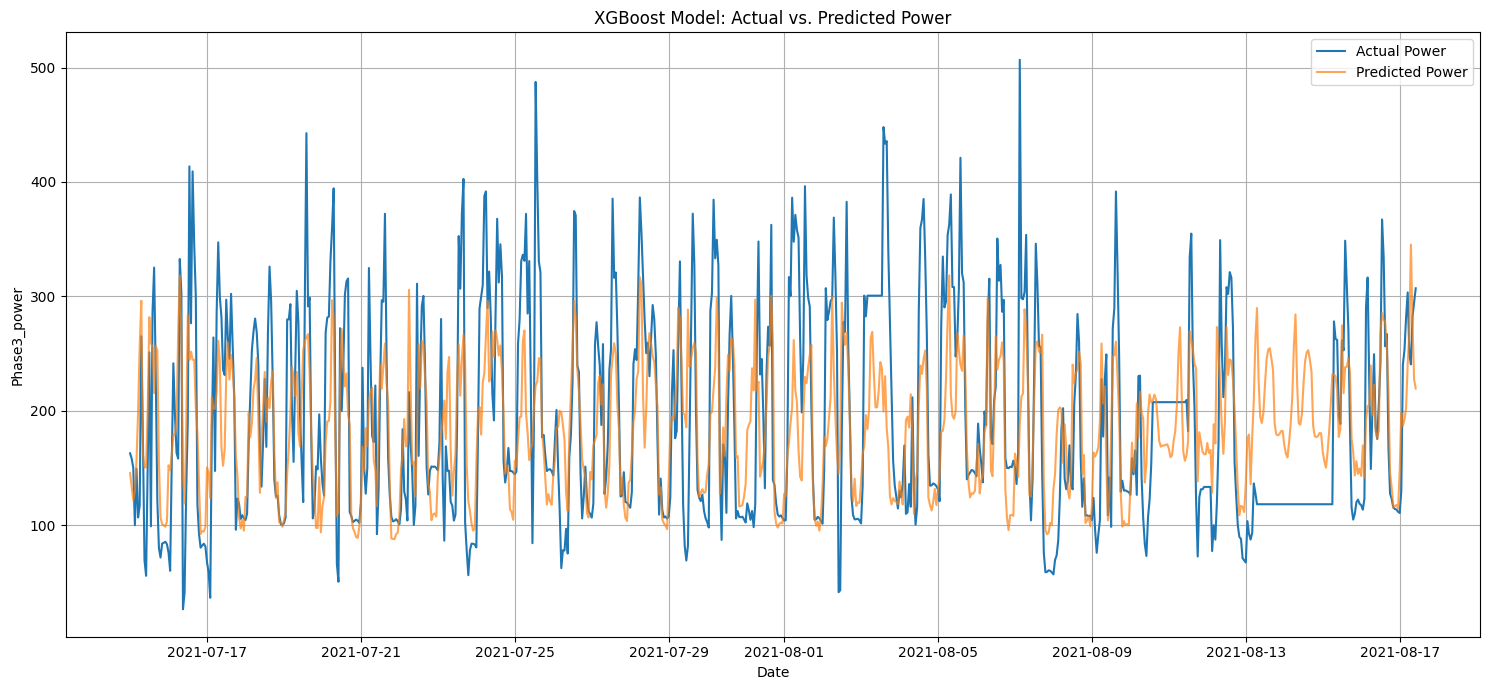

In [24]:
CHART_FILE = 'xgboost_prediction_vs_actual.png'
print(f"\nGenerating prediction plot... saving to {CHART_FILE}")

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(test_df.index, y_test, label='Actual Power')
plt.plot(test_df.index, predictions, label='Predicted Power', alpha=0.7)
plt.title('XGBoost Model: Actual vs. Predicted Power')
plt.xlabel('Date')
plt.ylabel(f'{TARGET}')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(CHART_FILE)

print("--- XGBoost Pipeline Complete ---")

--- Starting XGBoost Model Training (Lag & Rolling Features) ---
Loading cleaned data from data/cleaned_bangalore_data.csv...
Applying feature engineering (Time + Lag + Rolling)...
Target variable set to: Phase3_power
Splitting data into train/test sets at 2021-05-20...
Train set shape: (1017, 17), Test set shape: (2147, 17)
Training *TUNED* XGBoost Regressor model...
[0]	validation_0-rmse:95.98497	validation_1-rmse:112.44310
[100]	validation_0-rmse:45.51312	validation_1-rmse:84.58002
[200]	validation_0-rmse:23.50420	validation_1-rmse:77.90469
[300]	validation_0-rmse:13.17961	validation_1-rmse:75.35178
[400]	validation_0-rmse:8.08827	validation_1-rmse:74.70587
[498]	validation_0-rmse:5.19905	validation_1-rmse:74.57494
Model training complete.
Saving trained model to xgboost_model_final.joblib...
Model saved successfully: xgboost_model_final.joblib

--- Model Evaluation on VALID Test Set ---
Test Set RMSE: 74.4949
Test Set MAE:   59.0675
Test Set MAPE:   40.4405 %

MAPE: On average, the

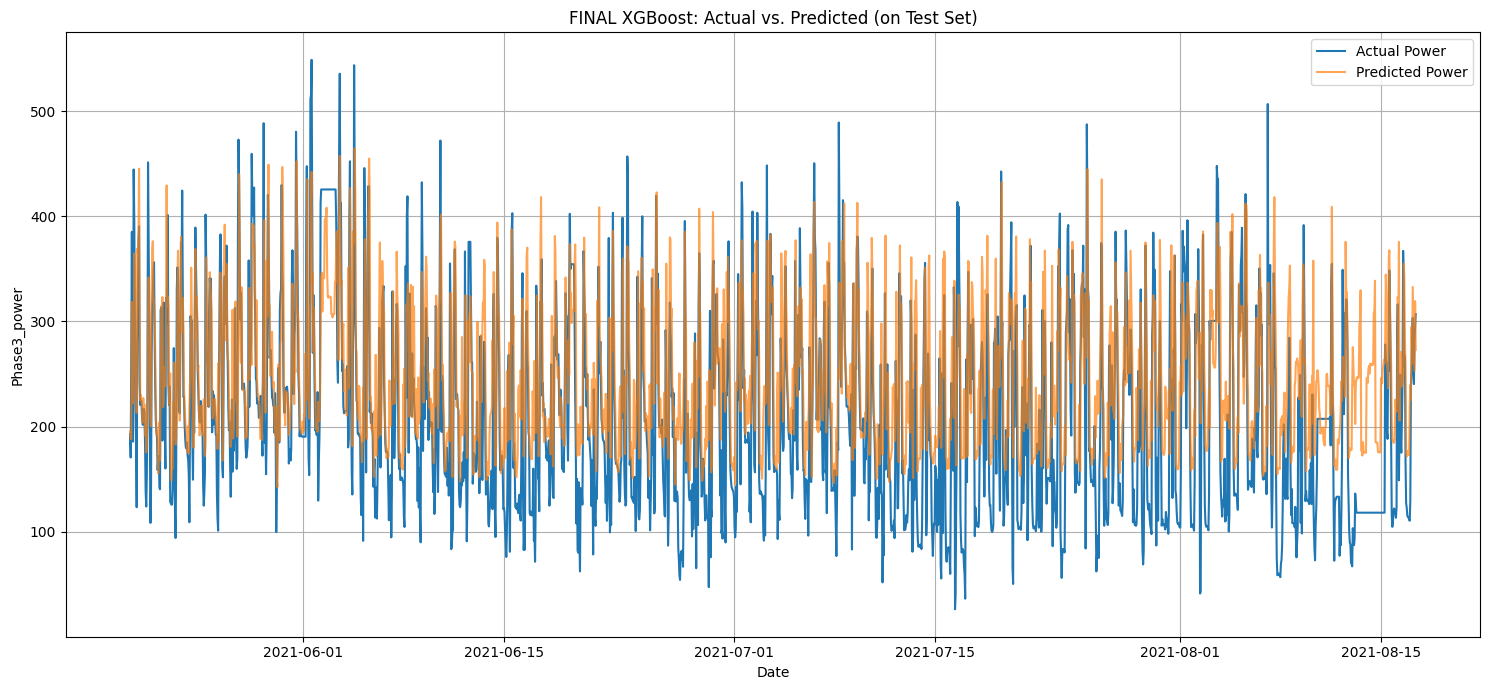

In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib
import os
import matplotlib.pyplot as plt
import numpy as np 

print("--- Starting XGBoost Model Training (Lag & Rolling Features) ---")

# --- Configuration ---
CLEANED_DATA_FILE = 'data/cleaned_bangalore_data.csv'
MODEL_FILE = 'xgboost_model_final.joblib' # Save as the final model
CHART_FILE = 'xgboost_prediction_vs_actual_final.png'

TARGET_COLUMN = 'Phase3_power' 

# --- Step 1: Feature Engineering (Upgraded) ---
def create_features(df, target_col):
    """
    Create time series features from a datetime index
    and add lag/rolling features.
    """
    df = df.copy()
    
    # 1. Time Features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    # 2. Lag Features
    # We use shift(1) to get the value from the *previous* hour.
    # This prevents "data leakage" (cheating).
    df[f'{target_col}_lag_1h'] = df[target_col].shift(1)
    df[f'{target_col}_lag_3h'] = df[target_col].shift(3)
    df[f'{target_col}_lag_24h'] = df[target_col].shift(24) # Power 1 day ago
    
    # 3. Rolling Window Features
    # Get the average of the last 3 hours, 6 hours, and 24 hours.
    # .shift(1) is crucial here for the same reason.
    df[f'{target_col}_roll_avg_3h'] = df[target_col].rolling(window=3).mean().shift(1)
    df[f'{target_col}_roll_avg_6h'] = df[target_col].rolling(window=6).mean().shift(1)
    df[f'{target_col}_roll_avg_24h'] = df[target_col].rolling(window=24).mean().shift(1)
    
    return df

print(f"Loading cleaned data from {CLEANED_DATA_FILE}...")
df = pd.read_csv(CLEANED_DATA_FILE, index_col='_time', parse_dates=True)

print("Applying feature engineering (Time + Lag + Rolling)...")
df = create_features(df, target_col=TARGET_COLUMN)


# --- Step 2: Define Target and Features ---
TARGET = TARGET_COLUMN
# Now we include all our new features
FEATURES = [
    'Phase2_current', 
    'Phase2_voltage', 
    'Phase3_frequency', 
    'Phase3_pf', 
    'Phase3_voltage',
    'hour', 
    'dayofweek', 
    'month', 
    'quarter', 
    'year', 
    'dayofyear',
    f'{TARGET}_lag_1h',
    f'{TARGET}_lag_3h',
    f'{TARGET}_lag_24h',
    f'{TARGET}_roll_avg_3h',
    f'{TARGET}_roll_avg_6h',
    f'{TARGET}_roll_avg_24h',
]
print(f"Target variable set to: {TARGET}")


# --- Step 3: Train/Test Split (Time-Based) ---
# The lag/rolling features create NaNs at the start. Drop them.
df.dropna(inplace=True) 

split_date = '2021-05-20' 
print(f"Splitting data into train/test sets at {split_date}...")

train_df = df.loc[df.index < split_date]
test_df = df.loc[df.index >= split_date]

if train_df.empty or test_df.empty:
    print(f"ERROR: Train or test set is empty. The split_date '{split_date}' may be outside your data's range.")
    print(f"Your data ranges from {df.index.min()} to {df.index.max()}.")
    exit()

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")


# --- Step 4: Train XGBoost Model ---
print("Training *TUNED* XGBoost Regressor model...")
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=10, 
    early_stopping_rounds=50,   
    eval_metric='rmse'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

print("Model training complete.")


# --- Step 5: Save the Trained Model ---
print(f"Saving trained model to {MODEL_FILE}...")
joblib.dump(model, MODEL_FILE)
print(f"Model saved successfully: {MODEL_FILE}")


# --- Step 6: Evaluate Model on Test Set ---
print("\n--- Model Evaluation on VALID Test Set ---")
predictions = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE:   {mae:.4f}")
print(f"Test Set MAPE:   {mape * 100:.4f} %")

print(f"\nMAPE: On average, the model's prediction is off by {mape*100:.2f}%. Your project KPI is < 2%.")


# --- Step 7: Visualize Results ---
print(f"\nGenerating prediction plot... saving to {CHART_FILE}")

plt.figure(figsize=(15, 7))
plt.plot(test_df.index, y_test, label='Actual Power')
plt.plot(test_df.index, predictions, label='Predicted Power', alpha=0.7)
plt.title('FINAL XGBoost: Actual vs. Predicted (on Test Set)')
plt.xlabel('Date')
plt.ylabel(f'{TARGET}')
plt.legend()
plt.grid(True)
plt.tight_layout()
# --- THIS IS THE TYPO FIX ---
plt.savefig(CHART_FILE)

print("--- XGBoost Pipeline Complete ---")

In [2]:
import pandas as pd
import xgboost as xgb
import joblib
import os
import numpy as np 

print("--- Starting XGBoost Model Training (100% PRODUCTION DATA) ---")

# --- Configuration ---
CLEANED_DATA_FILE = 'data/cleaned_bangalore_data.csv'
MODEL_FILE = 'xgboost_model_final.joblib' # We overwrite our final model

TARGET_COLUMN = 'Phase3_power' 

# --- Step 1: Feature Engineering ---
def create_features(df, target_col):
    """
    Create time series features from a datetime index
    and add lag/rolling features.
    """
    df = df.copy()
    
    # 1. Time Features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    # 2. Lag Features
    df[f'{target_col}_lag_1h'] = df[target_col].shift(1)
    df[f'{target_col}_lag_3h'] = df[target_col].shift(3)
    df[f'{target_col}_lag_24h'] = df[target_col].shift(24)
    
    # 3. Rolling Window Features
    df[f'{target_col}_roll_avg_3h'] = df[target_col].rolling(window=3).mean().shift(1)
    df[f'{target_col}_roll_avg_6h'] = df[target_col].rolling(window=6).mean().shift(1)
    df[f'{target_col}_roll_avg_24h'] = df[target_col].rolling(window=24).mean().shift(1)
    
    return df

print(f"Loading cleaned data from {CLEANED_DATA_FILE}...")
df = pd.read_csv(CLEANED_DATA_FILE, index_col='_time', parse_dates=True)

print("Applying feature engineering (Time + Lag + Rolling)...")
df = create_features(df, target_col=TARGET_COLUMN)


# --- Step 2: Define Target and Features ---
TARGET = TARGET_COLUMN
FEATURES = [
    'Phase2_current', 
    'Phase2_voltage', 
    'Phase3_frequency', 
    'Phase3_pf', 
    'Phase3_voltage',
    'hour', 
    'dayofweek', 
    'month', 
    'quarter', 
    'year', 
    'dayofyear',
    f'{TARGET}_lag_1h',
    f'{TARGET}_lag_3h',
    f'{TARGET}_lag_24h',
    f'{TARGET}_roll_avg_3h',
    f'{TARGET}_roll_avg_6h',
    f'{TARGET}_roll_avg_24h',
]
print(f"Target variable set to: {TARGET}")


# --- Step 3: Create Full Training Set (No Test Split) ---
# Drop NaNs created by lag/rolling features
df.dropna(inplace=True) 

# NO SPLIT. We use 100% of the data for training.
X_full = df[FEATURES]
y_full = df[TARGET]

print(f"Full training set shape: {X_full.shape}")


# --- Step 4: Train XGBoost Model on Full Data ---
print("Training *TUNED* XGBoost Regressor model on 100% of data...")
model = xgb.XGBRegressor(
    n_estimators=2000, # Using the tuned parameters
    learning_rate=0.01,
    max_depth=10, 
    early_stopping_rounds=50, # This will use the *training loss* for stopping
    eval_metric='rmse'
)

# We now fit on X_full and y_full
# We use (X_full, y_full) as the eval_set to monitor for early stopping.
model.fit(
    X_full, y_full,
    eval_set=[(X_full, y_full)],
    verbose=100
)

print("Model training complete.")


# --- Step 5: Save the Trained Model ---
print(f"Saving trained model to {MODEL_FILE}...")
joblib.dump(model, MODEL_FILE)
print(f"Model saved successfully: {MODEL_FILE}")

print("--- XGBoost Full Data Pipeline Complete ---")

--- Starting XGBoost Model Training (100% PRODUCTION DATA) ---
Loading cleaned data from data/cleaned_bangalore_data.csv...
Applying feature engineering (Time + Lag + Rolling)...
Target variable set to: Phase3_power
Full training set shape: (3164, 17)
Training *TUNED* XGBoost Regressor model on 100% of data...
[0]	validation_0-rmse:98.03667
[100]	validation_0-rmse:47.03682
[200]	validation_0-rmse:25.99614
[300]	validation_0-rmse:16.37959
[400]	validation_0-rmse:11.48342
[500]	validation_0-rmse:8.54712
[600]	validation_0-rmse:6.76280
[700]	validation_0-rmse:5.51415
[800]	validation_0-rmse:4.66772
[900]	validation_0-rmse:4.03890
[1000]	validation_0-rmse:3.55002
[1100]	validation_0-rmse:3.13083
[1200]	validation_0-rmse:2.73710
[1300]	validation_0-rmse:2.39080
[1400]	validation_0-rmse:2.12732
[1500]	validation_0-rmse:1.86922
[1600]	validation_0-rmse:1.64971
[1700]	validation_0-rmse:1.44440
[1800]	validation_0-rmse:1.22785
[1900]	validation_0-rmse:1.09456
[1999]	validation_0-rmse:0.97633
Mo